## Spectral measurements with Python and Ocean Optics USB2000+ spectrometer
## for converting maximal intensities of LEDs into photoisomerizations

#### Author: André Maia Chagas, Katrin Franke
#### CC BY 4.0.

The script below will allow the user to read in data with USB2000+ spectrometer, plot it and transform the output into photoisomerization per cone type and LED.

The spectrometer measurements rely on the open source library written by Andreas Pohlmann https://github.com/ap--.
The library is a wrapper for the C++ library written by Ocean Optics.

The installation instructions for the library and setup tips are here: https://github.com/ap--/python-seabreeze
Documentation is here: https://github.com/ap--/python-seabreeze/blob/master/docs/DOCUMENTATION.md

In [1]:
# import seabreeze (use 'pyseabreeze')
import seabreeze.spectrometers as sb

import os
import math
import numpy as np
import matplotlib.pyplot as plt

# set graphics to be plotted in the notebook
%matplotlib inline 

# for fitting gaussian to uv spectra
from scipy.optimize import curve_fit

import stimulator_calibration_lib as scl

#### Import calibration file sent by ocean optics
It contains for each wavelength the correspondent µJ/count correlation and it will be used to calibrate the readings from the spectrometer

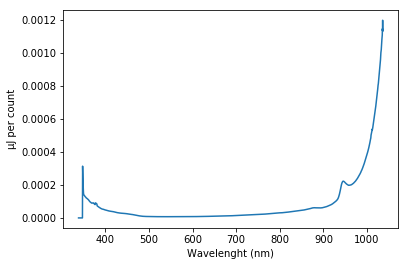

In [2]:
filePath = "C://Users//Eulerlab//Documents//Jupyter_notebooks//spectrometer//spectrometer_cal_20171101//"
filename = "USB2+F02461_20171108_CC.Irradcal" 

# open file
with open(filePath+filename, "r") as dummie:
    #read complete file and remove "\n"
    parsed = dummie.read().splitlines()

# parsed.index("[uJoule/count]")
#clean up list to get only the wavelengths and their values
parsed = parsed[parsed.index("[uJoule/count]")+1:]

# now split wavelengths and readout values
waves  = list()
values = list()
for item in parsed:
    waves.append(item[0:item.index("\t")])
    values.append(item[item.index("\t")+1:])

calib_values = np.array(values,dtype=float)
wavelengths  = np.array(waves,dtype=float)

plt.plot(wavelengths, calib_values)
plt.xlabel ("Wavelenght (nm)")
plt.ylabel("µJ per count")

#### Set the device

In [6]:
# set by serial number
spec = sb.Spectrometer.from_serial_number("USB2+F02461")

#### Set integration time in microseconds (change if output is saturated)

In [7]:
int_time_s = 1.0 # will be used to obtain µJ/s
int_time_ms = 1000*1000*(int_time_s) # in micro s
spec.integration_time_micros(int_time_ms)

#### Set device area in µm2

In [8]:
r_stimulus = 250 # in µm
A_detect_um2 = math.pi*(r_stimulus)**2

#### Measure beackground spectrum to subtract from green LED measurement

10.0% 20.0% 30.0% 40.0% 50.0% 60.0% 70.0% 80.0% 90.0% 100.0% 

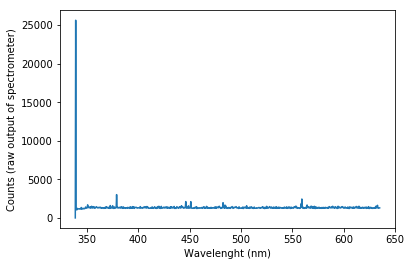

In [123]:
trials_baseline = 10 # specifies number of measurements for averaging
spec.trigger_mode(0) # spectrometer does not wait for a trigger
baseline = list()
for i in range(trials_baseline):
    wavelengths, intensities = spec.spectrum()
    baseline.append(intensities)
    print(str(((i+1)/trials_baseline)*100) + "% ", end='')
baseline_average = np.mean(baseline,axis=0)
plt.plot(wavelengths[0:800],baseline_average[0:800])
plt.xlabel ("Wavelenght (nm)")
plt.ylabel("Counts (raw output of spectrometer)")

#### Measure spectra for green LED

In [124]:
trials_spectra = 10

current_spectrum = list()
current_spectra = list()

for iT in range(trials_spectra):
    spec.trigger_mode(1)
    wavelengths, intensities = spec.spectrum()
    current_spectrum = intensities - baseline_average
    current_spectra.append(current_spectrum)
    print(str(round(((iT+1)/trials_spectra)*100)) + "% ", end='')
spectrum_green = np.mean(current_spectra, axis=0)

10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 

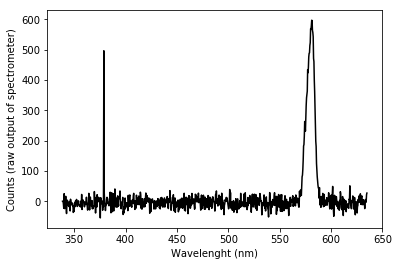

In [125]:
plt.plot(wavelengths[0:800],spectrum_green[0:800],color="k")
plt.xlabel ("Wavelenght (nm)")
plt.ylabel("Counts (raw output of spectrometer)")

#### Measure beackground spectrum to subtract from UV LED measurement

5% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 100% 

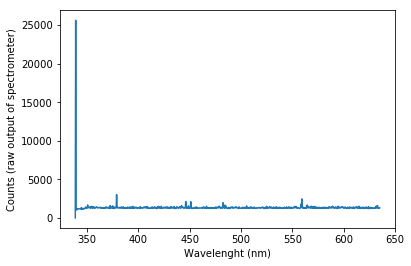

In [141]:
trials_baseline = 20 # specifies number of measurements for averaging
spec.trigger_mode(0) # spectrometer does not wait for a trigger
baseline = list()
for i in range(trials_baseline):
    wavelengths, intensities = spec.spectrum()
    baseline.append(intensities)
    print(str(round(((i+1)/trials_baseline)*100)) + "% ", end='')
baseline_average = np.mean(baseline,axis=0)
plt.plot(wavelengths[0:800],baseline_average[0:800])
plt.xlabel ("Wavelenght (nm)")
plt.ylabel("Counts (raw output of spectrometer)")

#### Measure spectra for UV LED

In [142]:
trials_spectra = 20
current_spectra = list()

for iT in range(trials_spectra):
    spec.trigger_mode(1)
    wavelengths, intensities = spec.spectrum()
    current_spectrum = intensities - baseline_average
    current_spectra.append(current_spectrum)
    print(str(round(((iT+1)/trials_spectra)*100)) + "% ", end='')
spectrum_uv = np.mean(current_spectra, axis=0)

5% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 100% 

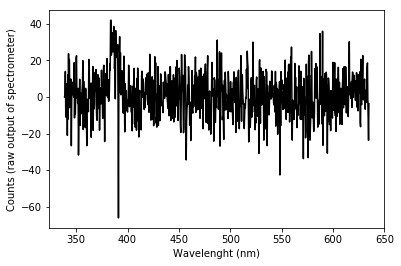

In [143]:
plt.plot(wavelengths[0:800],spectrum_uv[0:800],color="k")
plt.xlabel ("Wavelenght (nm)")
plt.ylabel("Counts (raw output of spectrometer)")
#plt.ylim([-5,200])

#### Gauss fit spectra

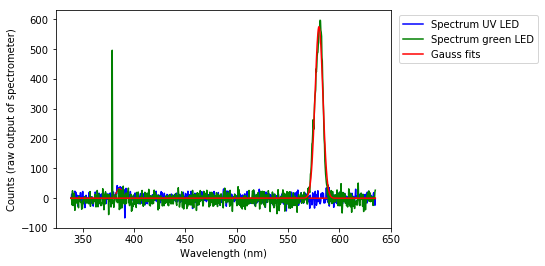

In [144]:
led_width = 10

def Gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

led_peak_uv = 387
x = wavelengths
y = spectrum_uv
a = y.max()
mean = led_peak_uv
sigma = led_width

popt, pcov = curve_fit(Gauss,x,y,p0=[a,mean,sigma])
fit_spectrum_uv = Gauss(x,popt[0],popt[1],popt[2])

led_peak_green = 576
x = wavelengths
y = spectrum_green
a = y.max()
mean = led_peak_green
sigma = led_width

popt, pcov = curve_fit(Gauss,x,y,p0=[a,mean,sigma])
fit_spectrum_green = Gauss(x,popt[0],popt[1],popt[2])

plt.plot(wavelengths[0:800],spectrum_uv[0:800],color="b",label="Spectrum UV LED")
plt.plot(wavelengths[0:800],fit_spectrum_uv[0:800],color="r")
plt.plot(wavelengths[0:800],spectrum_green[0:800],color="g",label="Spectrum green LED")
plt.plot(wavelengths[0:800],fit_spectrum_green[0:800],color="r",label="Gauss fits")
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Counts (raw output of spectrometer)")

#### Transform counts into Watts

41.790231147
15.1832281362


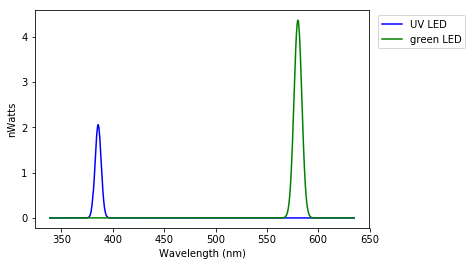

In [145]:
uv_nw = (np.multiply(fit_spectrum_uv,calib_values)/int_time_s)*1000
green_nw = (np.multiply(fit_spectrum_green,calib_values)/int_time_s)*1000

# resample spectra to 300...700 nm
start_nm = int(round(wavelengths[1]))
spectrum_uv_nw = list()
spectrum_green_nw = list()

for iS in range(700-300):
    if iS < (start_nm-300):
        spectrum_uv_nw.append(0)
        spectrum_green_nw.append(0)
    elif iS >= 39:
        index = np.where(wavelengths>=(300+iS))
        spectrum_uv_nw.append(uv_nw[index[0][0]])
    
        index = np.where(wavelengths>=(300+iS))
        spectrum_green_nw.append(green_nw[index[0][0]])

ymax = np.amax(spectrum_uv_nw)
spectrum_uv_nw_norm = spectrum_uv_nw/ymax
spectrum_uv_nw = np.array(spectrum_uv_nw, dtype=float)
spectrum_uv_nw_norm = np.array(spectrum_uv_nw_norm, dtype=float)

ymax = np.amax(spectrum_green_nw)
spectrum_green_nw_norm = spectrum_green_nw/ymax
spectrum_green_nw = np.array(spectrum_green_nw, dtype=float)
spectrum_green_nw_norm = np.array(spectrum_green_nw_norm, dtype=float)

plt.plot(wavelengths[0:800],uv_nw[0:800],color="b",label="UV LED")
plt.plot(wavelengths[0:800],green_nw[0:800],color="g",label="green LED")
plt.xlabel("Wavelength (nm)")
plt.ylabel("nWatts")
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

print(np.sum(spectrum_green_nw))
print(np.sum(spectrum_uv_nw))

### Definitions needed to transform µW into photoisomerizations

In [146]:
h        = 4.135667E-15 # Planck's constant [eV*s]
c        = 299792458    # speed of light [m/s]
eV_per_J = 6.242E+18    # [eV] per [J]

*   `ac_um2`<br />
    Cone OS light collection area in [µm^2], see [Nikonov et al., 2006](http://www.ncbi.nlm.nih.gov/pubmed/16567464) for details. This is an experimentally determined value, e.g. for wt mouse cones that is fully dark-adapted, a value of 0.2 can be assumed.
*   `ar_um2`<br />
    Rod OS light collection area, see above. A value of 0.5 is realistic.   


In [147]:
ac_um2 = 0.2     
ar_um2 = 0.5

In [148]:
pathData = "C://Users//eulerlab//Documents//Jupyter_notebooks//Calibration_Spectrometer//Data//"

Load opsin spectra from text files in the data folder defined above:
* Text files are expected to have one column per opsin ... 
* ... plus one (the last one) for the scaling in x direction (wavelength, in 1-nm increments).
* All spectral files, including the filter and LED files loaded later, must have the same x range. In this version, 300 .. 699 nm is used.

In [149]:
x_wavelen_nm = np.loadtxt(pathData +"mouse_cone_opsins.txt", usecols=(2,)) # 300 .. 699 nm
mouseMOpsin  = np.loadtxt(pathData +"mouse_cone_opsins.txt", usecols=(1,))
mouseSOpsin  = np.loadtxt(pathData +"mouse_cone_opsins.txt", usecols=(0,))

Define photoreceptors as a list of dictionaries, with:

*   `name`, name of photoreceptor, used later for plots etc.
*   `peak_nm`, peak wavelength of opsin spectrum in [nm]          
*   `collecArea_um2`, see above
*   `spect`, opsin spectrum

In [150]:
MCone = {"name"           : "mouse_M_cone",
         "peak_nm"        : 511,
         "collecArea_um2" : ac_um2, 
         "spect"          : mouseMOpsin}
SCone = {"name"           : "mouse_S_cone",
         "peak_nm"        : 360,         
         "collecArea_um2" : ac_um2, 
         "spect"          : mouseSOpsin}
Rod   = {"name"           : "mouse_rod",
         "peak_nm"        : 510,         
         "collecArea_um2" : ar_um2, 
         "spect"          : []}

PRs   = [MCone, SCone, Rod]

Define stimulus LED/filter combinations as a list of dictionaries, with:

*   `name`, name of LED/filter combinations, used later for plots etc.
*   `peak_nm`, peak wavelength of LED/filter combination in [nm]          
*   `bandwidth_nm`, LED/filter band width in [nm]. If 0 then the LED's spectrum is expected to be contained in `LED_spect` (same x range as the opsin spectra, see above, and with 1-nm resolution). Otherwise, the spectrum `spect` will be calculated, also acknowledging the filter `filter_spect`, if defined.
*   `LED_spect`, spectrum of LED
*   `filter_spect`, spectrum of filter
*   `spect`, resulting spectrum, is measured above

In [151]:
# LED spectra
#
LED_Green_Name     = "LED_Green_590"
LED_Green          = np.loadtxt(pathData +LED_Green_Name +".txt", usecols=(0,))

LED_UV_Name        = "LED_UV_385"
LED_UV             = np.loadtxt(pathData +LED_UV_Name +".txt", usecols=(0,))

# LED filter(s)
# (here, one two-band-pass filter is used instead of one for each LED)
#
#Dichr_UVGreen_name = "F59-003_390_575"
Filter_UV_Name     = "Filter_387_11"
Filter_UV          = np.loadtxt(pathData +Filter_UV_Name +".txt", usecols=(0,))
Filter_Green_Name  = "Filter_576_10"
Filter_Green       = np.loadtxt(pathData +Filter_Green_Name +".txt", usecols=(0,))

# Dicroic above the objective lens in the MOM
# (if not used, comment line that loads text file and uncomment next line)
#
#Dichr_Obj_name     = "F73-063_z400-580-890"
#Dichr_Obj          = np.loadtxt(pathData +Dichr_Obj_name +".txt", usecols=(0,))
#Dichr_Obj         = np.array(list([1.0]*len(LED_UV)))

In [1]:
# Example, where the LED/filter spectrum is calculated from the peak and 
# the width of a narrow filter (as, e.g. in setup 2)
#
"""
GrLED = {"name"         : "green",
         "peak_nm"      : 578,
         "bandwidth_nm" : 10,
         "LED_spect"    : [],
         "filter_spect" : [],
         "spect"        : [],
         "pow_meas_nW"  : GrLED_pow,
         "levels"       : GrLED_lev}
BlLED = {"name"         : "blue",
         "peak_nm"      : 400,
         "bandwidth_nm" : 20,
         "LED_spect"    : [],
         "filter_spect" : [],
         "spect"        : [],
         "pow_meas_nW"  : BlLED_pow,
         "levels"       : BlLED_lev}"""

# Example, where the spectrum of the LED/filter combination is calculated 
# from the LED spectrum and the filter spectrum (e.g. for the new LCr 
# two-band filter stimulator, setup 3)
#

GrLED = {"name"         : "green",
         "color"        : "g",
         "peak_nm"      : 576,
         "bandwidth_nm" : 0,
         "LED_spect"    : LED_Green,
         "filter_spect" : Filter_Green, 
         "spect"        : spectrum_green_nw_norm,
         "spect_nw"     : spectrum_green_nw}
UVLED = {"name"         : "UV",
         "color"        : "b",
         "peak_nm"      : 387,
         "bandwidth_nm" : 0,
         "LED_spect"    : LED_UV,
         "filter_spect" : Filter_UV,
         "spect"        : spectrum_uv_nw_norm,
         "spect_nw"     : spectrum_uv_nw}

LEDs  = [GrLED, UVLED]

for LED in LEDs:  
    colLED = scl.wavelength_to_rgb(LED["peak_nm"])
    plt.plot(x_wavelen_nm, LED["LED_spect"], color=colLED, label="LED_" +LED["name"], linewidth=0.5)
    plt.plot(x_wavelen_nm, LED["filter_spect"], "k", label="Filter_" +LED["name"], linewidth=1)
    plt.plot(x_wavelen_nm, LED["spect"], color=colLED, label="Spectrum_" +LED["name"])
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")
plt.xlabel("Wavelength (nm)")
plt.ylabel("")

NameError: name 'LED_Green' is not defined

# Determine effective photoreceptor stimulation

### Calculate spectra for effective LED/filter combinations 

In [153]:
for LED in LEDs:
    LED["effect_on_PR"] = []
    for PR in PRs:
        if len(PR["spect"]) > 0:
            temp = {}
            temp["PR_name"] = PR["name"]
            temp["spect"]   = PR["spect"] * LED["spect"]
            #A_PR            = np.trapz(PR["spect"])
            A_overlap       = np.trapz(temp["spect"])
            A_LED           = np.trapz(LED["spect"]) 
            temp["rel_exc"] = A_overlap/A_LED
            LED["effect_on_PR"].append(temp)

Plot spectra of photoreceptors and LED/filter combinations

Relative co-excitation:
  14.9% of mouse_M_cone by green
   0.0% of mouse_S_cone by green
  10.5% of mouse_M_cone by UV
  59.0% of mouse_S_cone by UV


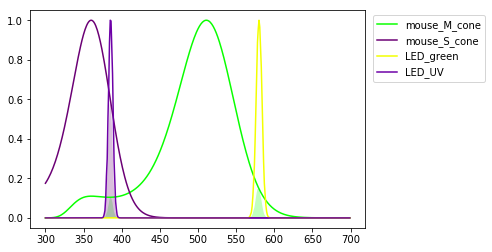

In [154]:
for PR in PRs:
    if len(PR["spect"]) > 0:
        plt.plot(x_wavelen_nm, PR["spect"], 
                 color=scl.wavelength_to_rgb(PR["peak_nm"]), label=PR["name"])
        
for LED in LEDs:        
    if len(LED["spect"]) > 0:    
        colLED = scl.wavelength_to_rgb(LED["peak_nm"])
        plt.plot(x_wavelen_nm, LED["spect"], color=colLED, label="LED_" +LED["name"])
        for effect in LED["effect_on_PR"]:
            for PR in PRs:
                if PR["name"] == effect["PR_name"]:
                    colPR = scl.wavelength_to_rgb(PR["peak_nm"])
            plt.fill(x_wavelen_nm, effect["spect"], facecolor=colPR, alpha=0.25)    

#sns.axlabel("wavelength [nm]", "rel. sensitivity or norm. transmission")     
plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")

# Print co-excitation values for all LED/filter and photoreceptor combinations
#
print("Relative co-excitation:")
for LED in LEDs:        
    if len(LED["spect"]) > 0:    
        for effect in LED["effect_on_PR"]:
            print("{0:6.1f}% of {1} by {2}"
                  .format(effect["rel_exc"]*100, effect["PR_name"], LED["name"]))    

Calculate photo-isomerization rates for all LED/filter and photoreceptor combinations

Range of photoisomerization rates:
 18.6 ..  18.6 10^3 photons/s in mouse_M_cone for green
  0.0 ..   0.0 10^3 photons/s in mouse_S_cone for green
  3.1 ..   3.1 10^3 photons/s in mouse_M_cone for UV
 17.7 ..  17.7 10^3 photons/s in mouse_S_cone for UV


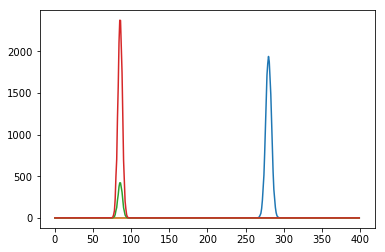

In [155]:
for iLED, LED in enumerate(LEDs):
    # Convert energy flux from [nW] (=readout of photometer, in [nW]) into [eV/s]
    #
    LED["pow_eflux"] = np.array((LED["spect_nw"] *1E-9 *eV_per_J),dtype=float)
    # Calculate the wavelength-dependent photon energy `Q` in [eV]
    #
    LED["pow_Q"]     = np.array((c*h/(x_wavelen_nm*1E-9)),dtype=float)
    # Divide energy flux by the photon energy to get the photon flux `phi`[photons/s] 
    # and then photon flux density `E` [photons/s /µm^2]
    #
    LED["pow_phi"]   = np.divide(LED["pow_eflux"],LED["pow_Q"])
    LED["pow_E"]     = LED["pow_phi"]/A_detect_um2
    # Calculate per photoreceptor ...
    #
    for effect in LED["effect_on_PR"]:
        for iPR, PR in enumerate(PRs):
            if PR["name"] == effect["PR_name"]:
                # ... photon flux per photoreceptor `photon_rate` in [photons/s]
                #
                A_collect = PR["collecArea_um2"]
                effect["photon_rate"]   = LED["pow_E"] *A_collect                
                # ... photoisomerizations [P*/photoreceptor /s]
                #
                effect["photoiso_rate"] = effect["photon_rate"] *effect["rel_exc"]
                effect["photoiso_rate_total"] = np.sum(effect["photoiso_rate"])
                plt.plot(effect["photoiso_rate"])
                if (iLED == 0) and (iPR == 0): 
                    print("Range of photoisomerization rates:")
                print("{0:5.1f} .. {1:5.1f} 10^3 photons/s in {2} for {3}"
                     .format(effect["photoiso_rate_total"]/1000.0, 
                             effect["photoiso_rate_total"]/1000.0, PR["name"], LED["name"]))